In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm

In [3]:
calls = pd.read_csv("AAPL.csv")
calls['DTE+Date'] = calls['DTE'].astype(str) + " " + calls['QUOTE_DATE'].astype(str)
daysTillExp = calls['DTE+Date'].unique()
calls["iv"] = 0

In [4]:
#
# S: Price Of Stock, K: Strike Price
# Sigma: Implied Volatility, t: years till expiration
# r: interest rate
#

#Theoretical Premium
def call_value(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

#Calculates the gradient
def call_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

#Uses Newton's method to find Implied volalility from theoretical premium
def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=5, itr=1000, verbose=False):
    iv = initial_guess
    for _ in range(itr):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"no convergence with {itr} iterations")
    return iv


In [6]:
daysTillExp[0]

'0.010958904109589  2016-01-04'

In [128]:
for day in daysTillExp[0:3]:
    calls_sub = calls.loc[lambda calls: calls['DTE+Date'] == day]
    calls["iv"] = calls_sub.apply(lambda row: bs_iv(row.PRICE, row.UNDERLYING_LAST, row.STRIKE, row.DTE, itr=500), axis=1)

C:\Users\pilug\AppData\Local\Temp/ipykernel_27276/250149363.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
C:\Users\pilug\AppData\Local\Temp/ipykernel_27276/250149363.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\pilug\AppData\Local\Temp/ipykernel_27276/250149363.py:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\pilug\AppData\Local\Temp/ipykernel_27276/250149363.py:10: RuntimeWarning: overflow encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\pilug\AppData\Local\Temp/ipykernel_27276/250149363.py:17: RuntimeWarning: overflow encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)


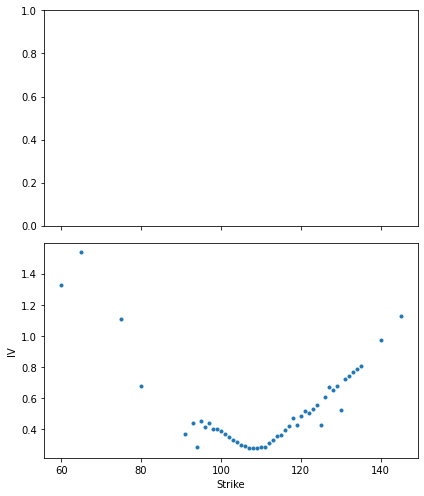

In [77]:
calls_no_na = calls.iloc[0:54].dropna()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,7), sharex=True)
ax2.plot(calls_no_na.STRIKE, calls_no_na.iv, ".")
ax2.set_ylabel("IV")
ax2.set_xlabel("Strike")
plt.tight_layout()
# plt.savefig("calls_to_iv.png", dpi=400)
plt.show()

In [103]:
calls_clean = calls_no_na.dropna().copy()
calls_clean["iv"] = scipy.ndimage.gaussian_filter1d(calls_clean.iv, 3)
calls_clean = calls_clean[(calls_clean.STRIKE > 95) & (calls_clean.STRIKE < 135)]

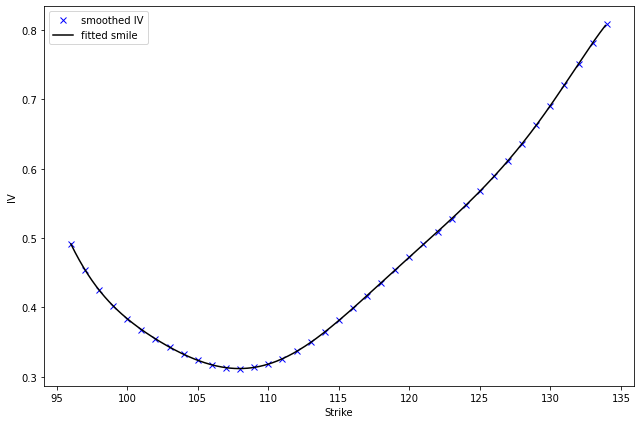

In [105]:
plt.figure(figsize=(9,6))
vol_surface = scipy.interpolate.interp1d(calls_clean.STRIKE, calls_clean.iv, kind="cubic",
                                 fill_value="extrapolate")
x_new = np.arange(calls_clean.STRIKE.min(), calls_clean.STRIKE.max(), 0.1)
plt.plot(calls_clean.STRIKE, calls_clean.iv, "bx", x_new, vol_surface(x_new), "k-");
plt.legend(["smoothed IV", "fitted smile"], loc="best")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.tight_layout()
# plt.savefig("SPY_smile.png", dpi=300)
plt.show()

In [117]:
x_new

array([ 96. ,  96.1,  96.2,  96.3,  96.4,  96.5,  96.6,  96.7,  96.8,
        96.9,  97. ,  97.1,  97.2,  97.3,  97.4,  97.5,  97.6,  97.7,
        97.8,  97.9,  98. ,  98.1,  98.2,  98.3,  98.4,  98.5,  98.6,
        98.7,  98.8,  98.9,  99. ,  99.1,  99.2,  99.3,  99.4,  99.5,
        99.6,  99.7,  99.8,  99.9, 100. , 100.1, 100.2, 100.3, 100.4,
       100.5, 100.6, 100.7, 100.8, 100.9, 101. , 101.1, 101.2, 101.3,
       101.4, 101.5, 101.6, 101.7, 101.8, 101.9, 102. , 102.1, 102.2,
       102.3, 102.4, 102.5, 102.6, 102.7, 102.8, 102.9, 103. , 103.1,
       103.2, 103.3, 103.4, 103.5, 103.6, 103.7, 103.8, 103.9, 104. ,
       104.1, 104.2, 104.3, 104.4, 104.5, 104.6, 104.7, 104.8, 104.9,
       105. , 105.1, 105.2, 105.3, 105.4, 105.5, 105.6, 105.7, 105.8,
       105.9, 106. , 106.1, 106.2, 106.3, 106.4, 106.5, 106.6, 106.7,
       106.8, 106.9, 107. , 107.1, 107.2, 107.3, 107.4, 107.5, 107.6,
       107.7, 107.8, 107.9, 108. , 108.1, 108.2, 108.3, 108.4, 108.5,
       108.6, 108.7,

In [116]:
vol_surface(x_new)

array([0.49162014, 0.48748409, 0.48344456, 0.4794998 , 0.47564799,
       0.47188737, 0.46821614, 0.46463253, 0.46113474, 0.45772099,
       0.4543895 , 0.45113848, 0.44796615, 0.44487072, 0.4418504 ,
       0.43890341, 0.43602797, 0.43322229, 0.43048459, 0.42781307,
       0.42520596, 0.42266146, 0.42017768, 0.41775272, 0.41538471,
       0.41307172, 0.41081189, 0.4086033 , 0.40644406, 0.40433227,
       0.40226605, 0.40024356, 0.39826326, 0.39632369, 0.39442336,
       0.39256081, 0.39073456, 0.38894315, 0.3871851 , 0.38545893,
       0.38376318, 0.38209646, 0.38045774, 0.37884607, 0.37726049,
       0.37570006, 0.37416382, 0.37265084, 0.37116015, 0.36969082,
       0.36824189, 0.3668125 , 0.36540213, 0.36401035, 0.36263674,
       0.36128086, 0.35994229, 0.3586206 , 0.35731535, 0.35602612,
       0.35475248, 0.35349406, 0.35225078, 0.35102261, 0.34980953,
       0.3486115 , 0.34742852, 0.34626056, 0.34510758, 0.34396957,
       0.3428465 , 0.3417384 , 0.34064545, 0.3395679 , 0.33850

In [118]:
x_new = np.arange(calls_clean.STRIKE.min(), calls_clean.STRIKE.max(), 0.1)

C_interp = call_value(calls_clean.UNDERLYING_LAST[12], x_new, vol_surface(x_new), calls_clean.DTE[12])

In [119]:
first_deriv = np.gradient(C_interp, x_new)
second_deriv = np.gradient(first_deriv, x_new)

In [4]:
def pdf2(Krange, S, t=0, r=0):
    Crange = call_value(S, Krange, vol_surface(Krange), t, r)
    
    first_deriv = np.gradient(Crange, x_new, edge_order=0)
    second_deriv = np.gradient(first_deriv, x_new, edge_order=0)

    return np.exp(r * t) * second_deriv

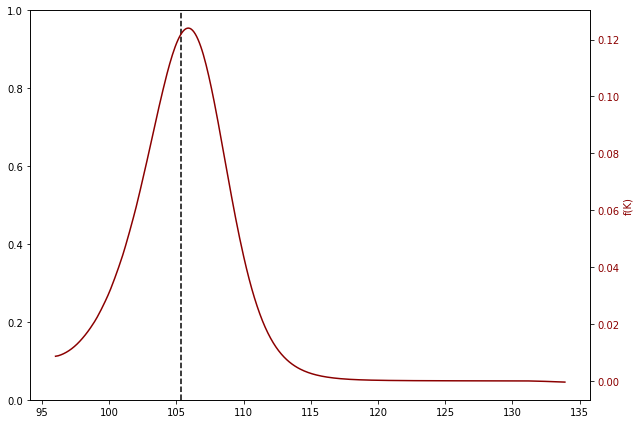

In [121]:
fig, ax1 = plt.subplots(figsize=(9,6))

ax2 = ax1.twinx()
ax1.axvline(calls_clean.UNDERLYING_LAST[12], color="k", linestyle="--")

col = 'darkred'
ax2.set_ylabel('f(K)', color=col)
ax2.plot(x_new, pdf2(x_new, calls_clean.UNDERLYING_LAST[12], calls_clean.DTE[12]), color=col)
ax2.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
# plt.savefig("volspace_pdf.png", dpi=300)
plt.show()